<a href="https://colab.research.google.com/gist/kykytsapol/317fd8cdee4e5350ada9d3db2d4230c9/-_-_nb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
df = pd.read_excel("10к_сентиментов.xlsx",index_col=0)
df.head()

,text_clear,label
91169,нетленка сети стесняемся заходим смотрим оцени...,1
102625,азаза ванга разрешила спокоен,1
129280,сегодня последняя серия молодежки пойду поплач...,0
43840,красивый желанный пока произнёс слова дзеуки д...,1
141571,чет сегодня радио т лагает детски,0


In [ ]:
X = df['text_clear']
y = df['label']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

In [ ]:
#настраиваем класс CountVectorizer- предупреждаем, что отбираем токены с частотностью не менее 2
vectorizer = CountVectorizer(min_df=2, max_features=10000)
#далее подаем в метод transform класса CountVectorizer столбец Текст_на_векторизацию
train_vectors = vectorizer.fit_transform(X_train.values.astype('U'))
test_vectors = vectorizer.transform(X_test.values.astype('U'))

Как было указано в литературном обзоре, я буду рассматривать два типа Наивного Баейвского классификатора: бернуллиевский и полиномиальный (или мультиноминальный)

In [ ]:
from sklearn.naive_bayes import MultinomialNB

nb = MultinomialNB()
nb.fit(train_vectors, y_train)

MultinomialNB()

In [ ]:
from sklearn.metrics import classification_report

Обучим сначала мультиноминальный классифкатор.

In [ ]:
# предсказываю результаты и вывожу оценку предсказания
predictions = nb.predict(test_vectors)
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.70      0.68      0.69     16402
           1       0.69      0.72      0.70     16598

    accuracy                           0.70     33000
   macro avg       0.70      0.70      0.70     33000
weighted avg       0.70      0.70      0.70     33000



In [ ]:
from sklearn.model_selection import GridSearchCV

С помощью сетки подберем опимальные параметры для модели. Я буду рассматривать модели на основе параметр аддитивного (Лапласа/Лидстоуна) сглаживания (alpha).

In [ ]:
params = {'alpha': [0.01, 0.1, 0.5, 1.0, 10.0]}

In [ ]:
nb_grid = GridSearchCV(MultinomialNB(), param_grid=params)
nb_grid.fit(train_vectors, y_train)

GridSearchCV(estimator=MultinomialNB(),
             param_grid={'alpha': [0.01, 0.1, 0.5, 1.0, 10.0]})

In [ ]:
# выводим лучшие параметры после обучения
print(nb_grid.best_params_)
 
# вот как наша модель выглядит после настройки гиперпараметров
print(nb_grid.best_estimator_)

{'alpha': 10.0}
MultinomialNB(alpha=10.0)


In [ ]:
# лучшее значение точности на обучающем множестве
print(nb_grid.best_score_)

0.6984328358208955


In [ ]:
# теперь посмотрим как наша модель работает на данных, которые она никогда не видела - на тестовом множестве
grid_predictions = nb_grid.predict(test_vectors)
 
# смотрим на classification report
print(classification_report(y_test, grid_predictions))

              precision    recall  f1-score   support

           0       0.70      0.68      0.69     16402
           1       0.70      0.71      0.70     16598

    accuracy                           0.70     33000
   macro avg       0.70      0.70      0.70     33000
weighted avg       0.70      0.70      0.70     33000



In [ ]:
from sklearn.metrics import roc_curve

In [ ]:
def get_roc_curve(model, X, y):
    pred = nb_grid.predict(X)
    fpr, tpr, _ = roc_curve(y, pred)
    return fpr, tpr

In [ ]:
roc_svm = get_roc_curve(nb_grid.best_estimator_, test_vectors, y_test)

In [ ]:
from sklearn.metrics import roc_auc_score

def score_auc(model, X, y):
    y_score = model.predict(X) 
    return roc_auc_score(y, y_score)

Еще считаем показатель AUC (площадь под кривой)

In [ ]:
score = score_auc(nb_grid.best_estimator_, test_vectors, y_test)
score

0.6983684926758629

In [ ]:
import matplotlib.pyplot as plt

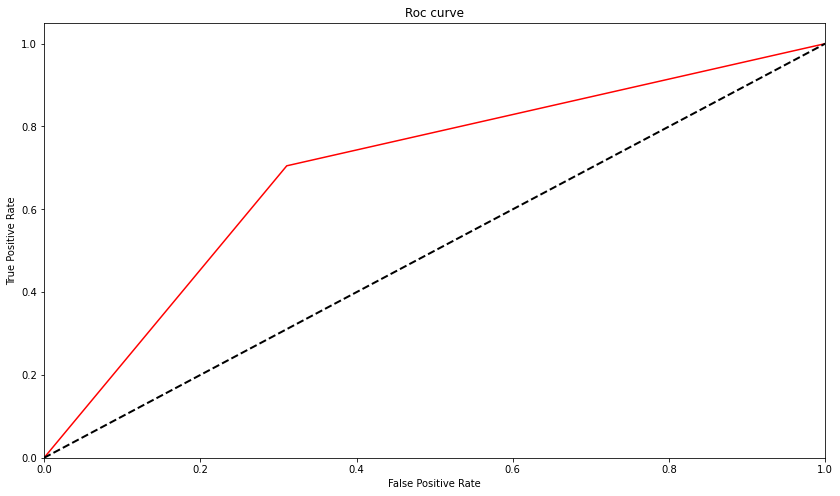

In [ ]:
fpr, tpr = roc_svm
plt.figure(figsize=(14,8))
plt.plot(fpr, tpr, color="red")
plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Roc curve')
plt.show()

### Для себя
Чем больше кривая ROC охватывает верхний левый угол графика, тем лучше модель классифицирует данные по категориям.

Чтобы дать количественную оценку, мы можем рассчитать AUC (площадь под кривой), которая говорит нам, какая часть графика расположена под кривой.

The closer AUC is to 1, the better the model.

A model with an AUC equal to 0.5 would be a perfectly diagonal line and it would represent a model that is no better than a model that makes random classifications.

Площаь равна 0,7. Это больше 0,5 :)

Также еще можно вывести матрицу ошибок

In [ ]:
from sklearn.metrics import confusion_matrix 

In [ ]:
import seaborn as sns

Text(23.999999999999996, 0.5, 'Actual')

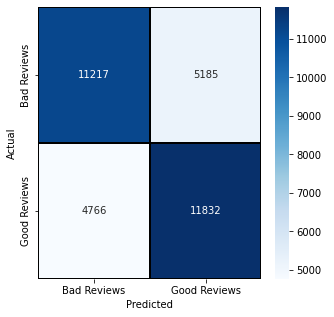

In [ ]:
cm = confusion_matrix(y_test, grid_predictions)
plt.figure(figsize = (5,5))
sns.heatmap(cm,cmap= "Blues", 
            linecolor = 'black', 
            linewidth = 1, 
            annot = True, 
            fmt='', 
            xticklabels = ['Bad Reviews','Good Reviews'], 
            yticklabels = ['Bad Reviews','Good Reviews'])
plt.xlabel("Predicted")
plt.ylabel("Actual")

In [ ]:
from sklearn.metrics import roc_auc_score

def score_auc(model, X, y):
    y_score = model.predict(X) 
    return roc_auc_score(y, y_score)

Посмотрим на бернулевский классификатор. 

In [ ]:
from sklearn.naive_bayes import BernoulliNB

In [ ]:
# обучаю модель на тестовом сете
model = BernoulliNB(alpha=10.0)
model.fit(train_vectors, y_train)
 
# предсказываю результаты и вывожу оценку предсказания
predictions = model.predict(test_vectors)
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.71      0.68      0.69     16246
           1       0.70      0.73      0.71     16754

    accuracy                           0.70     33000
   macro avg       0.70      0.70      0.70     33000
weighted avg       0.70      0.70      0.70     33000



In [ ]:
params = {'alpha': [0.01, 0.1, 0.5, 1.0, 10.0]}

In [ ]:
nb_grid_ber = GridSearchCV(BernoulliNB(), param_grid=params)
nb_grid_ber.fit(train_vectors, y_train)

GridSearchCV(estimator=BernoulliNB(),
             param_grid={'alpha': [0.01, 0.1, 0.5, 1.0, 10.0]})

In [ ]:
# выводим лучшие параметры после обучения
print(nb_grid_ber.best_params_)
 
# вот как наша модель выглядит после настройки гиперпараметров
print(nb_grid_ber.best_estimator_)

{'alpha': 10.0}
BernoulliNB(alpha=10.0)


In [ ]:
# лучшее значение точности на обучающем множестве
print(nb_grid_ber.best_score_)

0.6973731343283582


In [ ]:
# теперь посмотрим как наша модель работает на данных, которые она никогда не видела - на тестовом множестве
grid_predictions = nb_grid_ber.predict(test_vectors)
 
# смотрим на classification report
print(classification_report(y_test, grid_predictions))

              precision    recall  f1-score   support

           0       0.71      0.68      0.69     16246
           1       0.70      0.73      0.71     16754

    accuracy                           0.70     33000
   macro avg       0.70      0.70      0.70     33000
weighted avg       0.70      0.70      0.70     33000



In [ ]:
def get_roc_curve(model, X, y):
    pred = nb_grid_ber.predict(X)
    fpr, tpr, _ = roc_curve(y, pred)
    return fpr, tpr

In [ ]:
roc_svm = get_roc_curve(nb_grid_ber.best_estimator_, test_vectors, y_test)

In [ ]:
from sklearn.metrics import roc_auc_score

def score_auc(model, X, y):
    y_score = model.predict(X) 
    return roc_auc_score(y, y_score)

In [ ]:
score = score_auc(nb_grid_ber.best_estimator_, test_vectors, y_test)
score

0.6978664548490592

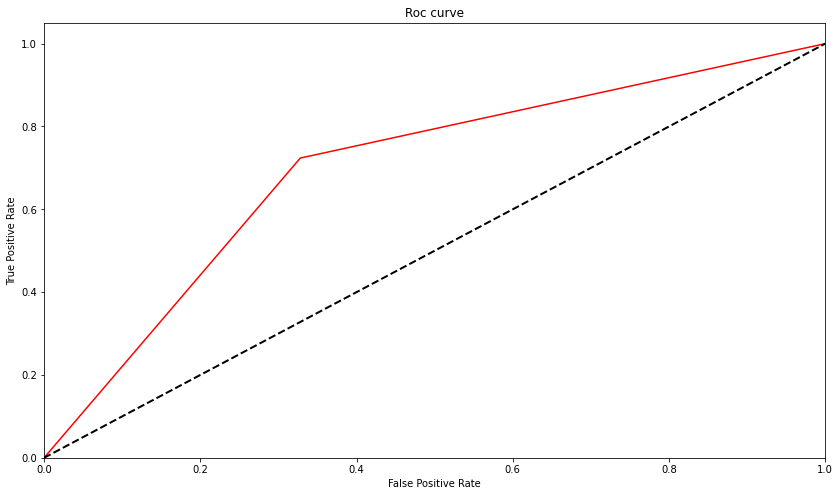

In [ ]:
fpr, tpr = roc_svm
plt.figure(figsize=(14,8))
plt.plot(fpr, tpr, color="red")
plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Roc curve')
plt.show()

Text(23.999999999999996, 0.5, 'Actual')

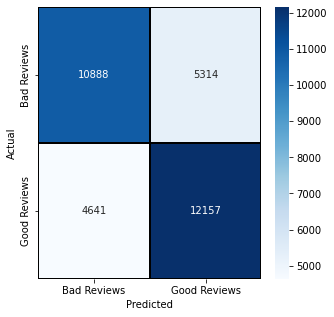

In [ ]:
cm = confusion_matrix(y_test, grid_predictions)
plt.figure(figsize = (5,5))
sns.heatmap(cm,cmap= "Blues", 
            linecolor = 'black', 
            linewidth = 1, 
            annot = True, 
            fmt='', 
            xticklabels = ['Bad Reviews','Good Reviews'], 
            yticklabels = ['Bad Reviews','Good Reviews'])
plt.xlabel("Predicted")
plt.ylabel("Actual")

In [ ]:
score = score_auc(model, test_vectors, y_test)
score

0.6978664548490592

In [ ]:
data1 = pd.read_excel("доминирующие_топики_доковида.xlsx", usecols = 'C, F, G')
data1.head()

,Доминирующий_топик,Оригинальный_текст,Преобразованный_текст
0,0,Эксперты раскрывают многие магические секреты....,эксперт раскрывать многий магический секрет хо...
1,0,гаданием на картах таро увлеклась моя знакомая...,гадание карта таро увлекаться знакомый дом при...
2,1,Любовь надо искать на своей улице....мораль се...,любовь искать улица мораль сей басня худо добро
3,0,"Деньги это не главное , главное Любовь на всю...",деньги главный главное любовь
4,2,моя бабушка любит мистические истории,бабушка любить мистический история


In [ ]:
text = vectorizer.transform(data1["Преобразованный_текст"].values.astype('U'))

In [ ]:
sentiment_text = model.predict(text)

In [ ]:
data1['sentiment_text'] = sentiment_text
data1

,Доминирующий_топик,Оригинальный_текст,Преобразованный_текст,sentiment_text
0,0,Эксперты раскрывают многие магические секреты....,эксперт раскрывать многий магический секрет хо...,0
1,0,гаданием на картах таро увлеклась моя знакомая...,гадание карта таро увлекаться знакомый дом при...,0
2,1,Любовь надо искать на своей улице....мораль се...,любовь искать улица мораль сей басня худо добро,1
3,0,"Деньги это не главное , главное Любовь на всю...",деньги главный главное любовь,1
4,2,моя бабушка любит мистические истории,бабушка любить мистический история,0
...,...,...,...,...
30400,1,Хочется узнать есть ли у меня порча или нет.,хотеться узнавать порча,1
30401,0,Rima Versuliene . А я не видела себя. Значит в...,видеть ерунда,1
30402,0,О ком вы хотели сказать.Мне на самом деле очен...,самый дело плохо,0
30403,0,"Аня ты умничка, весь расклад совпадает",умничек расклад совпадать,1


In [ ]:
# смотрим сколько всего негавтивных и позитивных текстов.
data1.groupby('sentiment_text').sentiment_text.count()

sentiment_text
0     8391
1    22014
Name: sentiment_text, dtype: int64

In [ ]:
data11 = pd.read_excel("доминирующие_топики_послековида.xlsx", usecols = 'C, F, G')
data11.head()

,Доминирующий_топик,Оригинальный_текст,Преобразованный_текст
0,3,тайм-коды:\n0:10 - Флаг! ⚡\n0:25 - до начала э...,тайм код флаг начало эфир эхо москва детск...
1,7,Жаль до моргенштерна не добрались.,жаль моргенштерн добираться
2,3,"Невзоров в перерыве, говоря о Вассермане, сказ...",невзоров перерыв говоритьссерман настольпотряс...
3,3,"Многие удивляются, - а почему так быстро свари...",многие удивляться быстро свариватькцина причем...
4,6,Спасибо! Про Дуню забавно. А что если и Вассер...,дуня забавноссерман баба сиська борода похоже ...


In [ ]:
text = vectorizer.transform(data11["Преобразованный_текст"].values.astype('U'))

In [ ]:
sentiment_text = model.predict(text)

In [ ]:
data11['sentiment_text'] = sentiment_text
data11

,Доминирующий_топик,Оригинальный_текст,Преобразованный_текст,sentiment_text
0,3,тайм-коды:\n0:10 - Флаг! ⚡\n0:25 - до начала э...,тайм код флаг начало эфир эхо москва детск...,1
1,7,Жаль до моргенштерна не добрались.,жаль моргенштерн добираться,0
2,3,"Невзоров в перерыве, говоря о Вассермане, сказ...",невзоров перерыв говоритьссерман настольпотряс...,1
3,3,"Многие удивляются, - а почему так быстро свари...",многие удивляться быстро свариватькцина причем...,1
4,6,Спасибо! Про Дуню забавно. А что если и Вассер...,дуня забавноссерман баба сиська борода похоже ...,1
...,...,...,...,...
54782,4,шанс всегда хорошо виден - распознать нетрудно...,шанс видный распознавать нетрудно трудно решаться,0
54783,0,Ю\n\n\n\n\n\n\n\n\n\nЮ,ю ю,1
54784,5,А сами расклад смотрите?????? Зачем???,расклад смотреть,1
54785,7,Та же самая история!!!,самый история,1


In [ ]:
# смотрим сколько всего негавтивных и позитивных текстов.
data11.groupby('sentiment_text').sentiment_text.count()

sentiment_text
0    17122
1    37665
Name: sentiment_text, dtype: int64

In [ ]:
data1.to_excel('оценка_тональности_всех_текстов_доковида_nb.xlsx')
data11.to_excel('оценка_тональности_всех_текстов_послековида_nb.xlsx')

In [ ]:
data2 = pd.read_excel("только_топики_доковида.xlsx", index_col = 0)
data2.head()

,Ключевые_слова
Топик,
0,"расклад, знать, благодарить, хороший, отношени..."
1,"таро, благодарить, видео, огромный, большой, к..."
2,"карта, колода, вопрос, таро, говорить, мир, ар..."


In [ ]:
topic1 = vectorizer.transform(data2["Ключевые_слова"])

In [ ]:
sentiment_topic = model.predict(topic1)

In [ ]:
data2['sentiment_text'] = sentiment_topic
data2

,Ключевые_слова,sentiment_text
Топик,,
0,"расклад, знать, благодарить, хороший, отношени...",1
1,"таро, благодарить, видео, огромный, большой, к...",1
2,"карта, колода, вопрос, таро, говорить, мир, ар...",0


In [ ]:
data3 = pd.read_excel("только_топики_послековида.xlsx", index_col = 0)
data3

,Ключевые_слова
Топик,
0,"март, февраль, карта, прогноз, выходить, месяц..."
1,"ребенок, жить, друг, любить, мужчина, женщина,..."
2,"благодарить, благо, желать, счастие, бог, дава..."
3,"говорить, игра, знак, язык, ангел, сила, война..."
4,"понимать, видеть, говорить, слово, помогать, в..."
5,"расклад, благодарить, смотреть, делать, вопрос..."
6,"таро, канал, видео, карта, комментарий, поддер..."
7,"украина, россия, мир, война, страна, донбасс, ..."


In [ ]:
topic2 = vectorizer.transform(data3["Ключевые_слова"])

In [ ]:
sentiment_topic = model.predict(topic2)

In [ ]:
data3['sentiment_text'] = sentiment_topic
data3

,Ключевые_слова,sentiment_text
Топик,,
0,"март, февраль, карта, прогноз, выходить, месяц...",0
1,"ребенок, жить, друг, любить, мужчина, женщина,...",1
2,"благодарить, благо, желать, счастие, бог, дава...",1
3,"говорить, игра, знак, язык, ангел, сила, война...",1
4,"понимать, видеть, говорить, слово, помогать, в...",0
5,"расклад, благодарить, смотреть, делать, вопрос...",1
6,"таро, канал, видео, карта, комментарий, поддер...",1
7,"украина, россия, мир, война, страна, донбасс, ...",1


In [ ]:
data1.groupby("Доминирующий_топик").aggregate({'sentiment_text': 'mean'})

,sentiment_text
Доминирующий_топик,
0,0.638157
1,0.833411
2,0.700563


In [ ]:
data11.groupby("Доминирующий_топик").aggregate({'sentiment_text': 'mean'})

,sentiment_text
Доминирующий_топик,
0,0.473611
1,0.585019
2,0.852239
3,0.715960
4,0.647050
5,0.749881
6,0.787372
7,0.707201


In [ ]:
data1['sentiment_text'] = data1['sentiment_text'].apply(lambda x: "позитивное" if x == 1 else "негативное")

In [ ]:
data1.groupby(["Доминирующий_топик", 'sentiment_text']).Доминирующий_топик.aggregate('count')

Доминирующий_топик  sentiment_text
0                   негативное        4108
                    позитивное        7245
1                   негативное        1783
                    позитивное        8920
2                   негативное        2500
                    позитивное        5849
Name: Доминирующий_топик, dtype: int64

In [ ]:
data11['sentiment_text'] = data11['sentiment_text'].apply(lambda x: "позитивное" if x == 1 else "негативное")

In [ ]:
data11.groupby(["Доминирующий_топик", 'sentiment_text']).Доминирующий_топик.aggregate('count')

Доминирующий_топик  sentiment_text
0                   негативное        4149
                    позитивное        3733
1                   негативное        3119
                    позитивное        4397
2                   негативное        1343
                    позитивное        7746
3                   негативное        1139
                    позитивное        2871
4                   негативное        2297
                    позитивное        4211
5                   негативное        2097
                    позитивное        6287
6                   негативное         953
                    позитивное        3529
7                   негативное        2025
                    позитивное        4891
Name: Доминирующий_топик, dtype: int64

In [ ]:
data1.to_excel('оценка_тональности_всего_доковида_nb.xlsx')
data11.to_excel('оценка_тональности_всего_послековида_nb.xlsx')